<a href="https://colab.research.google.com/github/Ifeanyi-Ezeigwe/Skin-Cancer-image-Classifer/blob/main/SID_2193800_Projectcode(Time_series).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##IMPORTING THE NECESSARY LIBRARIES

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
from pandas import read_csv
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, SimpleRNN
from keras.layers import ConvLSTM2D, Flatten, Bidirectional
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [ ]:
# The dataset for this project from read in from my google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)  
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

## READ DATA

In [ ]:
# Load the dataset

df = pd.read_csv('/content/drive/MyDrive/Colab_files/AML_Assig/AQI_data.csv', parse_dates=True)


df.head()

,End Date,End Time,M_DIR,Status/units,M_SPED,Status/units.1,M_T,Status/units.2,NO,Status/units.3,NO2,Status/units.4,NOXasNO2,Status/units.5
0,2013-01-01,01:00:00,297.4,P deg,6.2,P ms-1,7.3,P degC,32.84640,R ugm-3,51.17149,R ugm-3,101.53526,R ugm-3
1,2013-01-01,02:00:00,307.8,P deg,6.1,P ms-1,7.1,P degC,27.13626,R ugm-3,44.21700,R ugm-3,85.82535,R ugm-3
2,2013-01-01,03:00:00,301.1,P deg,5.9,P ms-1,6.2,P degC,24.90983,R ugm-3,35.60023,R ugm-3,73.79477,R ugm-3
3,2013-01-01,04:00:00,296.2,P deg,6.0,P ms-1,5.0,P degC,34.57516,R ugm-3,55.13546,R ugm-3,108.14996,R ugm-3
4,2013-01-01,05:00:00,288.6,P deg,5.8,P ms-1,4.3,P degC,37.91480,R ugm-3,53.17754,R ugm-3,111.31276,R ugm-3


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87648 entries, 0 to 87647
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   End Date        87648 non-null  object 
 1   End Time        87648 non-null  object 
 2   M_DIR           84984 non-null  float64
 3   Status/units    84984 non-null  object 
 4   M_SPED          84984 non-null  float64
 5   Status/units.1  84984 non-null  object 
 6   M_T             84984 non-null  float64
 7   Status/units.2  84984 non-null  object 
 8   NO              82438 non-null  float64
 9   Status/units.3  82438 non-null  object 
 10  NO2             82428 non-null  float64
 11  Status/units.4  82428 non-null  object 
 12  NOXasNO2        82428 non-null  float64
 13  Status/units.5  82428 non-null  object 
dtypes: float64(6), object(8)
memory usage: 9.4+ MB


In [ ]:
df.describe()

,M_DIR,M_SPED,M_T,NO,NO2,NOXasNO2
count,84984.000000,84984.000000,84984.000000,82438.000000,82428.000000,82428.000000
mean,204.233813,4.716914,9.478827,29.493053,29.490052,74.704161
std,92.770325,2.506298,5.807048,36.101035,15.966583,67.959776
min,0.000000,0.000000,-7.500000,-0.138980,0.935070,2.103720
25%,147.900000,2.900000,5.200000,6.457962,17.487030,28.563505
50%,226.300000,4.200000,9.300000,16.790870,27.083310,54.175555
75%,268.700000,6.100000,13.600000,38.652265,38.958955,98.175440
max,360.000000,20.300000,30.100000,455.858840,240.127280,756.071020


## PREPROCESSING & DATA ANALYSIS TASKS

In [ ]:
#Change column names
df = df[['End Date', 'End Time', 'M_SPED', 'M_T', 'NO', 'NO2', 'NOXasNO2']]
df.columns = ['date', 'time', 'speed', 'temperature', 'no', 'no2', 'nox_as_no2']

df.head()

,date,time,speed,temperature,no,no2,nox_as_no2
0,2013-01-01,01:00:00,6.2,7.3,32.84640,51.17149,101.53526
1,2013-01-01,02:00:00,6.1,7.1,27.13626,44.21700,85.82535
2,2013-01-01,03:00:00,5.9,6.2,24.90983,35.60023,73.79477
3,2013-01-01,04:00:00,6.0,5.0,34.57516,55.13546,108.14996
4,2013-01-01,05:00:00,5.8,4.3,37.91480,53.17754,111.31276


<Axes: >

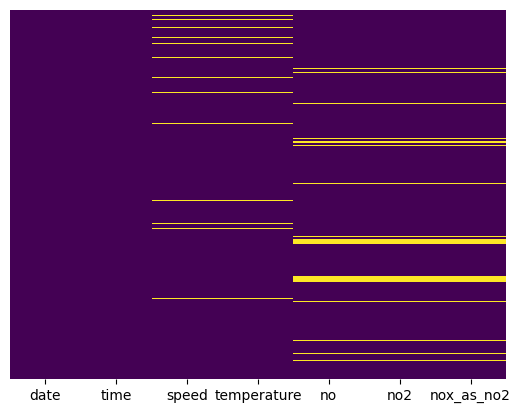

In [ ]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [ ]:
#we use Linear Interpolation technique to impute the missing values in the data frame or series 
#here we assume that there is a linear r/ship betwwen the data points

df[['speed']] = df[['speed']].interpolate(method='linear')
df[['temperature']] = df[['temperature']].interpolate(method='linear')
df[['no']] = df[['no']].interpolate(method='linear')
df[['no2']] = df[['no2']].interpolate(method='linear')
df[['nox_as_no2']] = df[['nox_as_no2']].interpolate(method='linear')

<Axes: >

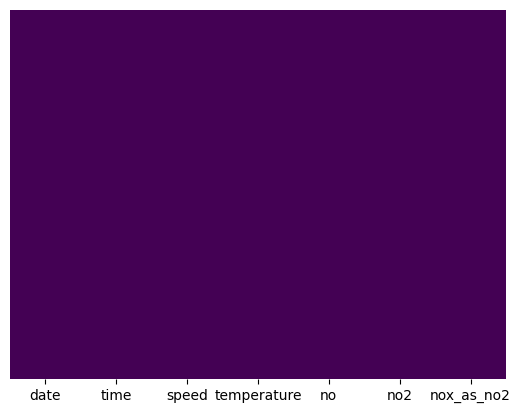

In [ ]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [ ]:
# we downsampled the dataset from hourly to daily in order to make prediction based on the daily observations
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.drop(columns=['time'])

# Daily
df = df.groupby(pd.Grouper(freq='D', key='date')).mean()

In [ ]:
df.head()

,speed,temperature,no,no2,nox_as_no2
date,,,,,
2013-01-01,6.970833,4.987500,13.158314,25.879877,46.055677
2013-01-02,6.041667,6.241667,67.438951,42.469566,145.874517
2013-01-03,6.445833,10.425000,55.694895,38.263939,123.661586
2013-01-04,5.283333,8.516667,64.855768,44.247959,143.692082
2013-01-05,4.575000,6.991667,65.344245,42.556133,142.749245


###Calculation for the Individual AQI for the 3 major pollutants we are considering
####The range for this calculation was gotten from the UK Department for Environment Food & Rural Affairs 
####https://uk-air.defra.gov.uk/air-pollution/daqi?view=more-info

In [ ]:
# calculating the individual pollutant index for no ( nitric oxide)
def calculate_no_index(no):
    if no <= 40:
        index = no * 50 / 40
    elif no <= 80:
        index = 50 + (no - 40) * (50 / 40)
    elif no <= 180:
        index = 100 + (no - 80) * (100 / 100)
    elif no <= 280:
        index = 200 + (no - 180) * (100 / 100)
    elif no <= 400:
        index = 300 + (no - 280) * (100 / 120)
    else:
        index = 400 + (no - 400) * (100 / 120)
    return index

df['noi'] = df['no'].apply(calculate_no_index)
data = df[['no', 'noi']]
data.head()


,no,noi
date,,
2013-01-01,13.158314,16.447892
2013-01-02,67.438951,84.298689
2013-01-03,55.694895,69.618619
2013-01-04,64.855768,81.069710
2013-01-05,65.344245,81.680307


In [ ]:
# calculating the individual pollutant index for no2(nitrogen dioxide)
def calculate_aqi_no2(no2):
    if no2 <= 67:
        aqi = no2 * 50 / 67
    elif no2 <= 134:
        aqi = 50 + (no2 - 67) * 50 / 67
    elif no2 <= 267:
        aqi = 100 + (no2 - 134) * 100 / 133
    elif no2 <= 400:
        aqi = 200 + (no2 - 267) * 100 / 133
    else:
        aqi = 300 + (no2 - 400) * 100 / 120
    return aqi

df['no2i'] = df['no2'].apply(calculate_aqi_no2)
data = df[['no2', 'no2i']]
data.head()



,no2,no2i
date,,
2013-01-01,25.879877,19.313341
2013-01-02,42.469566,31.693706
2013-01-03,38.263939,28.555178
2013-01-04,44.247959,33.020865
2013-01-05,42.556133,31.758308


In [ ]:
# calculating the individual pollutant index for noXasno2

def cal_nox_as_no2i(nox_as_no2):
    nox_as_no2i = 0
    if nox_as_no2 <= 40:
        nox_as_no2i = nox_as_no2 * 50 / 40
    elif nox_as_no2 > 40 and nox_as_no2 <= 80:
        nox_as_no2i = 50 + (nox_as_no2 - 40) * (50 / 40)
    elif nox_as_no2 > 80 and nox_as_no2 <= 180:
        nox_as_no2i = 100 + (nox_as_no2 - 80) * (100 / 100)
    elif nox_as_no2 > 180 and nox_as_no2 <= 280:
        nox_as_no2i = 200 + (nox_as_no2 - 180) * (100 / 100)
    elif nox_as_no2 > 280 and nox_as_no2 <= 400:
        nox_as_no2i = 300 + (nox_as_no2 - 280) * (100 / 120)
    else:
        nox_as_no2i = 400 + (nox_as_no2 - 400) * (100 / 120)
    return nox_as_no2i

df['nox_as_no2i'] = df['nox_as_no2'].apply(cal_nox_as_no2i)
data = df[['nox_as_no2', 'nox_as_no2i']]
data.head()


,nox_as_no2,nox_as_no2i
date,,
2013-01-01,46.055677,57.569596
2013-01-02,145.874517,165.874517
2013-01-03,123.661586,143.661586
2013-01-04,143.692082,163.692082
2013-01-05,142.749245,162.749245


In [ ]:
# Caluclating the Air Quality Index.
def cal_aqi(noi,no2i,noXasno2i):
    aqi=0
    if(noi>no2i and noi>noXasno2i):
     aqi=noi
    if(no2i>noi and no2i>noXasno2i):
     aqi=no2i
    if(noXasno2i>noi and noXasno2i>no2i):
     aqi=noXasno2i
    return aqi

df['AQI'] = df.apply(lambda x:cal_aqi(x['noi'],x['no2i'],x['nox_as_no2i']),axis=1)
data= df[['noi','no2i','nox_as_no2i','AQI']]
data.head()


,noi,no2i,nox_as_no2i,AQI
date,,,,
2013-01-01,16.447892,19.313341,57.569596,57.569596
2013-01-02,84.298689,31.693706,165.874517,165.874517
2013-01-03,69.618619,28.555178,143.661586,143.661586
2013-01-04,81.069710,33.020865,163.692082,163.692082
2013-01-05,81.680307,31.758308,162.749245,162.749245


In [ ]:
df_aqi = df.filter(['AQI'], axis=1)

dataset = df_aqi.values
dataset = dataset.astype('float32')


In [ ]:
# decompose the time series into trend, seasonality, and residual
decomposition = seasonal_decompose(df['AQI'], model='additive')

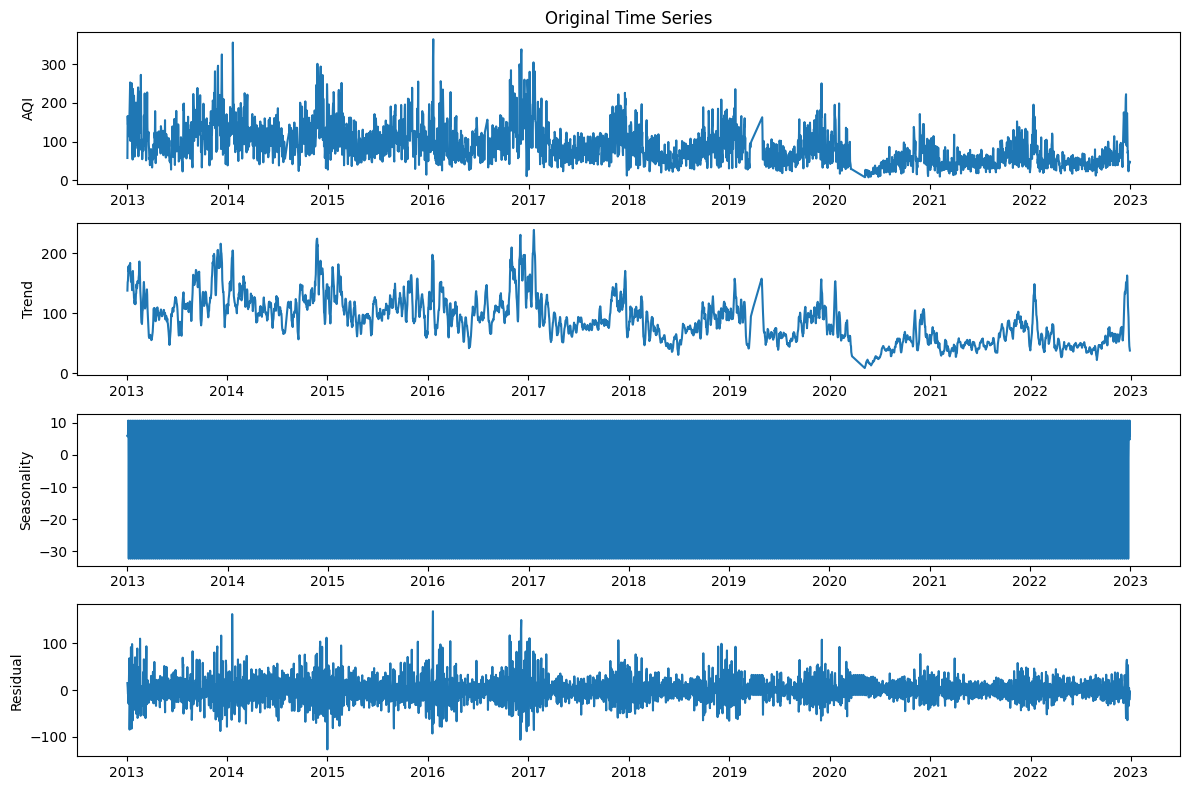

In [ ]:
# plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8))
ax1.plot(df['AQI'])
ax1.set_ylabel('AQI')
ax1.set_title('Original Time Series')
ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')
ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonality')
ax4.plot(decomposition.resid)
ax4.set_ylabel('Residual')
plt.tight_layout()
plt.show()

In [ ]:
df_aqi.head()

,AQI
date,
2013-01-01,57.569596
2013-01-02,165.874517
2013-01-03,143.661586
2013-01-04,163.692082
2013-01-05,162.749245


<Axes: xlabel='date'>

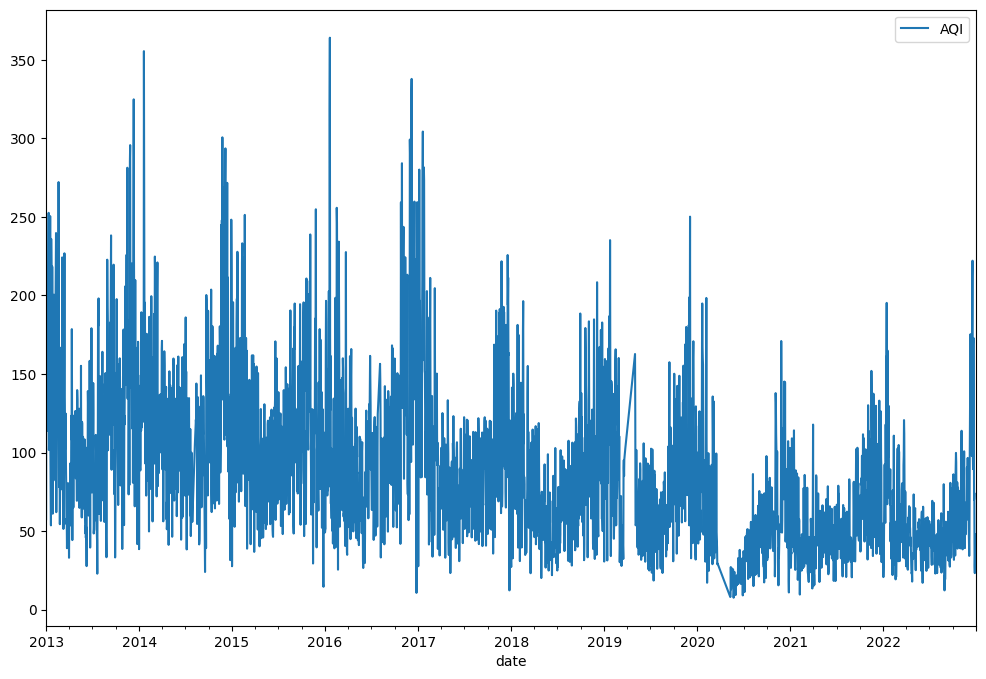

In [ ]:
#Plot the data - Year vs AQI
df_aqi.plot(figsize=(12,8))

In [ ]:
dataset = df_aqi

In [ ]:
dataset.head()

,AQI
date,
2013-01-01,57.569596
2013-01-02,165.874517
2013-01-03,143.661586
2013-01-04,163.692082
2013-01-05,162.749245


In [ ]:
# normalize the dataset into a range of 0's and 1's 
#in order to improve the performance of the model and reduce the impact of different scales of features

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

### We will use split the data using a non-random technique, 
### because we are working with time series problem, random shuffling of the dataset can break the time dependencies

In [ ]:
# Non-random splitting of the dataset into train and test sets.
#Train Size is 67% of the data and test size is 33%
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [ ]:
# Generates batches for sequence data

from keras.preprocessing.sequence import TimeseriesGenerator 
seq_size = length =  1 
batch_size = 1
train_generator = TimeseriesGenerator(train,train,length=length,batch_size=batch_size)
print("Total number of samples in the original training data = ", len(train)) 
print("Total number of samples in the generated data = ", len(train_generator)) 



Total number of samples in the original training data =  2446
Total number of samples in the generated data =  2445


In [ ]:
# print a couple of samples... 
x, y = train_generator[0]

In [ ]:
#Also generate validation data
validation_generator = TimeseriesGenerator(test, test, length=length ,batch_size=batch_size)

In [ ]:
#Input dimensions are... (N x seq_size)
num_features = 1 #Univariate example

In [ ]:
#We shift the data to have the current date and the next date on the same row
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

## MODELING PHASE
## This code considered different model, 
## specifically single LSTM model, bidirectional, ConvLSTM and simpleRNN


In [ ]:
#LSTM single layer with 50 units, 1 Dense layer

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(length, num_features)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer = 'adam' )

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 50)                10400     
                                                                 
 dense_18 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Stacked LSTM with 50 units, 1 Hidden layer and 1 Dense layer
# first we reshape input to be [samples, time steps, features]

#trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

#model = Sequential()
#model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(length, num_features)))
#model.add(LSTM(50, activation='relu'))
#model.add(Dense(32, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))
#model.compile(loss='mean_squared_error', optimizer='adam')

#model.summary()


In [ ]:
#Multi-layers LSTM with 32 units each and a dropout layer of 0.2 rate applied after each LSTM layer

#Reshaping the input data
#trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

#model = Sequential()
#model.add(LSTM(32, activation='relu', return_sequences = True, input_shape=(trainX.shape[1], trainX.shape[2])))
#model.add(Dropout(0.2))

#model.add(LSTM(32, return_sequences = True))
#model.add(Dropout(0.2))

#model.add(LSTM(32))
#model.add(Dropout(0.2))

#model.add(Dense(1, activation='sigmoid'))

#model.compile(optimizer = 'adam', loss = 'mean_squared_error')
#model.summary()

In [ ]:
#Bidirectional LSTM model with 1 layer of 50 units, and 1 Dense layer
# reshape input to be [samples, time steps, features]

#trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

##For some sequence forecasting problems we may need LSTM to learn
## sequence in both forward and backward directions

#from keras.layers import Bidirectional
#model = Sequential()
#model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(None, seq_size)))
#model.add(Dense(1, activation='sigmoid'))
#model.compile(loss='mean_squared_error', optimizer='adam')

#model.summary()


In [ ]:
#Single ConvLSTM2D layer with 64 filters and a kernel size of (1,1) and the ReLU activation function

#The layer expects input as a sequence of two-dimensional images, 
#therefore the shape of input data must be: [samples, timesteps, rows, columns, features]

#trainX = trainX.reshape((trainX.shape[0], 1, 1, 1, seq_size))
#testX = testX.reshape((testX.shape[0], 1, 1, 1, seq_size))

#from keras.layers import ConvLSTM2D, Flatten
#model = Sequential()
#model.add(ConvLSTM2D(filters=64, kernel_size=(1,1), activation='relu', input_shape=(1, 1, 1, seq_size)))
#model.add(Flatten())
#model.add(Dense(32))
#model.add(Dense(1, activation='sigmoid'))
#model.compile(loss='mean_squared_error', optimizer='adam')

#model.summary()


In [ ]:
#SimpleRNN with 64 units and 1 Dense layer


#model = Sequential()
#model.add(SimpleRNN(64, input_shape=(length, num_features), activation='relu'))
#model.add(Dense(1, activation='sigmoid'))
#model.compile(loss='mean_squared_error', optimizer='adam')

#model.summary() 

In [ ]:
history = model.fit(
    trainX, trainY, 
    epochs=50, 
    batch_size=1, 
    verbose=2
    )

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

38/38 [==============================] - 0s 2ms/step


In [ ]:
# invert predictions we scaled some steps before
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [ ]:
# calculate root mean squared error
# The mean square error is the average of the square of the difference 
# between the observed and predicted values of a variable. 

trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 40.72 RMSE
Test Score: 36.30 RMSE


## For this step we are moving back the data to for to align the x-axis, we moved it during data preparation and plot the predictions


In [ ]:
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [ ]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan

#testPredictPlot[len(trainPredict)+(seq_size*2)-1:len(dataset)-1, :] = testPredict
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

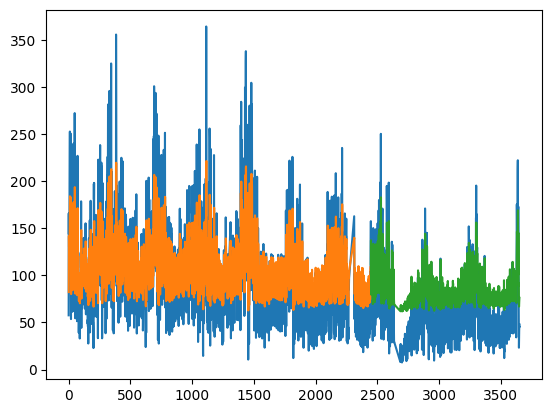

In [ ]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()